## QRS Detector

This notebook trains a CNN/LSTM hybrid model based to identify a QRS complex in ECG data. The model performance is then evaluated on testing (holdout) data.

#### NOTE : 
The previous notebook, gen_train_test_data.ipynp, created train.pkl and test.pkl files, which are the training and testing sets, respectively. In generating that dataset, the data is randomly shuffled. Therefore, the training and testing set used for the pretrained model will be different from the one generated if you ran gen_train_test_data yourself.

If you use the provided pretrained model, delete train.pkl and test.pkl from your local drive, and run this script (which will automatically download the train.pkl and test.pkl files used for the pretrained model).

Import stuff

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import pickle
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pywt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed, Flatten, LSTM, Bidirectional, Dropout, BatchNormalization, Conv2D, Activation, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_normal

#!pip install googledrivedownloader
#from google_drive_downloader import GoogleDriveDownloader as gdd

Define some constants

In [7]:
#LSTM parameters
WIN_LEN = 256    #window of data as input
NUM_CHAN = 62    #number of "channels" of the time series data, ie the length of the y axis of the scaleogram
VAL_SPLIT = 0.30 #percentage for validation split during training
BATCH_SIZE = 32  #batch size
EPOCHS = 30      #number of epochs

#define the frequencies for the cwt
wavelet = 'morl'
scales = np.arange(2,64)  #this corresponds to ~1.5Hz - 50Hz
wavelet_freqs = pywt.scale2frequency(wavelet, scales)*256

Download the training/testing datasets (as generated from gen_train_test_data.ipynp) and model. Note that these are 500MB+ files so it may take some time to download.

In [8]:
'''
#download train.pkl
train_file_id = '1-USgA2AgpY2FPKpAKAaHiopFYnKgTBDv'
gdd.download_file_from_google_drive(file_id=train_file_id, dest_path='./train.pkl')

#download test.pkl
test_file_id = '1Iwndy_bPQ2-sUnuTSx2yFDwHlVWR9wdy'
gdd.download_file_from_google_drive(file_id=test_file_id, dest_path='./test.pkl')

#download model.h5
model_file_id = '1-pMg5qyNAu16cDFJgKhFMZqigWaGuJ8y'
gdd.download_file_from_google_drive(file_id=model_file_id, dest_path='./model.h5')

#download history.pkl
history_file_id = '1BZj8xH3yV0giAwE4oF2Xb0MS6SpjJtyM'
gdd.download_file_from_google_drive(file_id=history_file_id, dest_path='./history.pkl')
'''

"\n#download train.pkl\ntrain_file_id = '1-USgA2AgpY2FPKpAKAaHiopFYnKgTBDv'\ngdd.download_file_from_google_drive(file_id=train_file_id, dest_path='./train.pkl')\n\n#download test.pkl\ntest_file_id = '1Iwndy_bPQ2-sUnuTSx2yFDwHlVWR9wdy'\ngdd.download_file_from_google_drive(file_id=test_file_id, dest_path='./test.pkl')\n\n#download model.h5\nmodel_file_id = '1-pMg5qyNAu16cDFJgKhFMZqigWaGuJ8y'\ngdd.download_file_from_google_drive(file_id=model_file_id, dest_path='./model.h5')\n\n#download history.pkl\nhistory_file_id = '1BZj8xH3yV0giAwE4oF2Xb0MS6SpjJtyM'\ngdd.download_file_from_google_drive(file_id=history_file_id, dest_path='./history.pkl')\n"

Load the separate training and testing sets

In [9]:
data_train = pd.read_pickle('train.pkl')

X_train = np.array([np.reshape(x, (WIN_LEN,NUM_CHAN)) for x in data_train['window'].values])
X_train = np.expand_dims(X_train,3)
y_train = np.array([y for y in data_train['label'].values])
y_train = to_categorical(np.expand_dims(y_train, axis=2))

data_test = pd.read_pickle('test.pkl')
#print(data_test['r'][500:1000])
X_test = np.array([np.reshape(x, (WIN_LEN,NUM_CHAN)) for x in data_test['window'].values])
X_test = np.expand_dims(X_test,3)
y_test = np.array([y for y in data_test['label'].values])
y_test = to_categorical(np.expand_dims(y_test, axis=2))
ecg_test = np.array([data for data in data_test['data'].values])
r_test = np.array([r for r in data_test['r'].values])


In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26886, 256, 62, 1)
(2987, 256, 62, 1)
(26886, 256, 2)
(2987, 256, 2)


Build the model

In [11]:
#first CNN
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=5, padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.25))

#second CNN
model.add(Conv2D(filters=32, kernel_size=5, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.25))

#first LSTM. note that we need to do a timedistributed flatten as a transition from CNN to LSTM
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.25)))

#second LSTM. note that we need to do a timedistributed flatten as a transition from CNN to LSTM
model.add(Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.25)))

#dense layer
model.add(TimeDistributed(Dense(5, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#activation layer
model.add(TimeDistributed(Dense(2, activation='softmax')))

#compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

model.summary()


/Users/guhaojia/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-11 16:53:23.924687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-11 16:53:23.925623: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 16:53:23.925908: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 16:53:23.925954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 16:53:23.926160: I tensorflow/core/common_runtime/pluggable_device/pluggable_dev

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 62, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 62, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 62, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 15, 32)    │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 15, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 256, 3, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 3, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 256, 96)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 200)       │       157,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256, 100)       │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 256, 5)         │           505 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 5)         │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 256, 2)         │            12 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,257 (1.09 MB)

 Trainable params: 285,119 (1.09 MB)

 Non-trainable params: 138 (552.00 B)

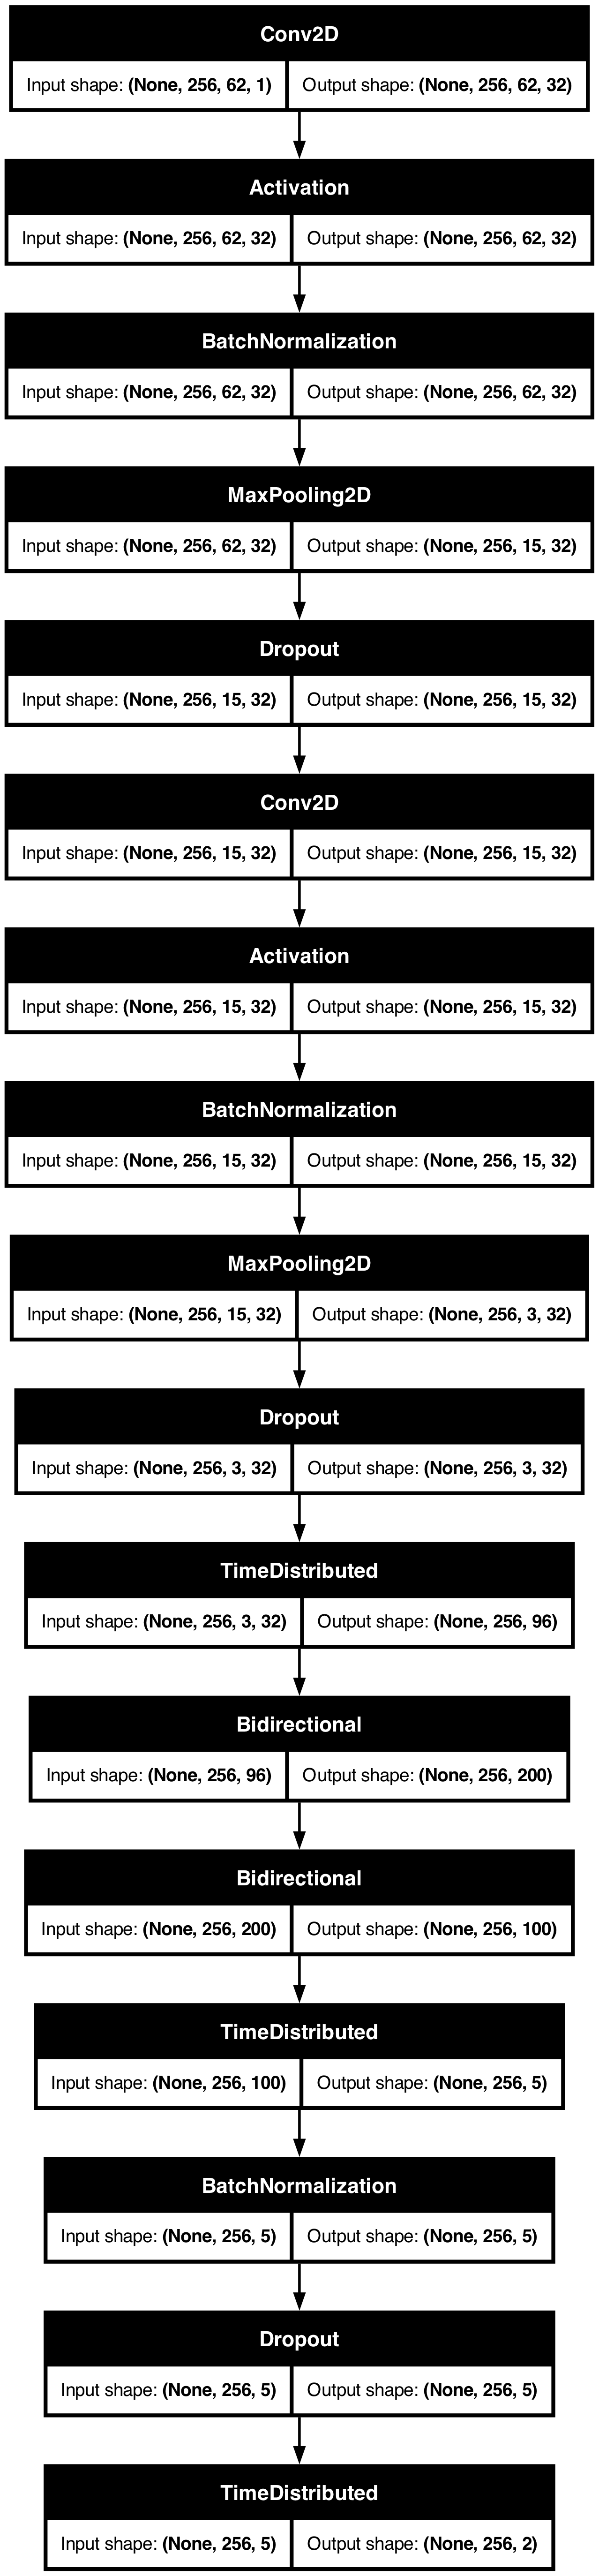

In [12]:
#draw model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


Train the model. Note that the pretrained model has already been downloaded above, so just load that model instead of running the training again. If you want to run the training again, set do_training to True. 

In [13]:
do_training = False

if do_training:
    #monitor validation loss for early stopping
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

    history = model.fit(
      X_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      callbacks=[early_stop],
      shuffle=True,
      validation_split=VAL_SPLIT,
    )
    
    history = history.history
    model.save('model.h5')
    pickle.dump(history, open('history.pkl', 'wb'))

else:
    model = load_model('qrs_model.keras')
    history = pickle.load(open('history.pkl', 'rb'))

In [14]:
model.save('qrs_model.keras')

Plot the accuracy and loss

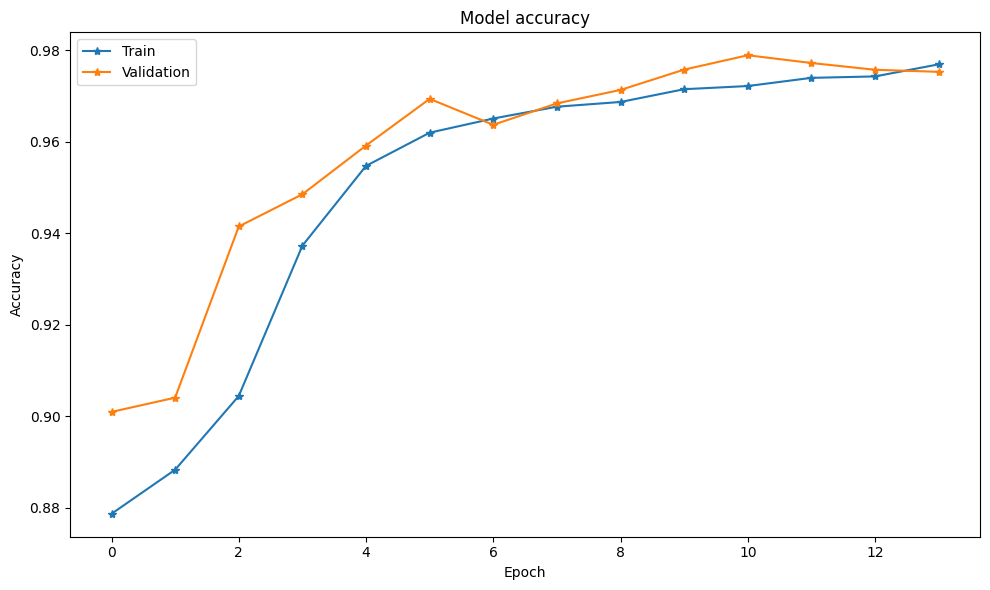

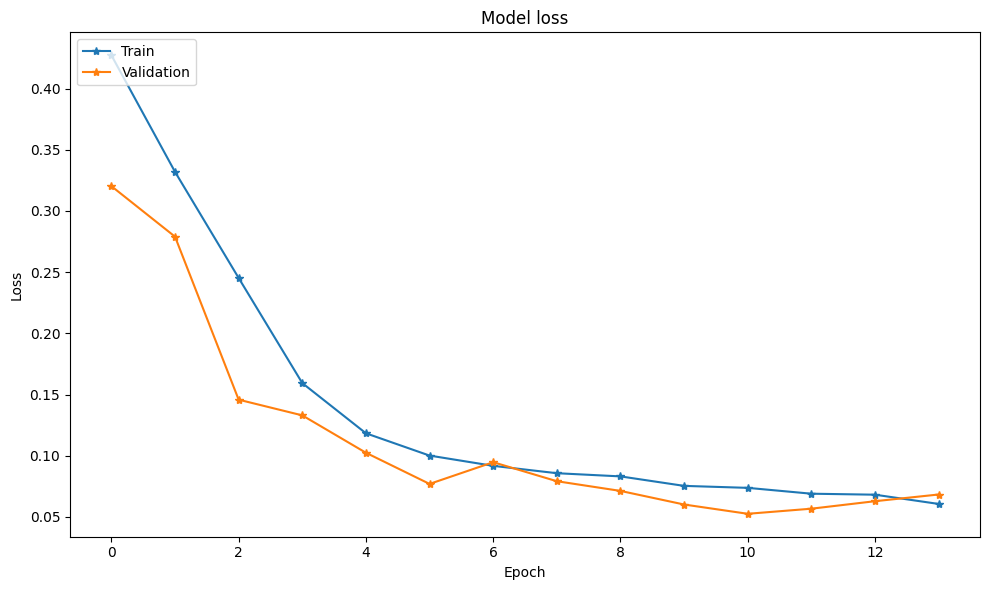

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,6))
plt.plot(history['accuracy'], '*-')
plt.plot(history['val_accuracy'], '*-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('plots/accuracy.png', dpi=250)
plt.show()
plt.close()

# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history['loss'], '*-')
plt.plot(history['val_loss'], '*-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('plots/loss.png', dpi=250)
plt.show()
plt.close()


Define a function to calculate the ROC. In addition to calculating the ROC, this function will return the probability threshold associated with the maximized f1 score.

In [16]:
def roc(predictions, true):
    predictions = predictions.flatten()
    true = true.flatten()

    thresh_vals = [i/25 for i in range(26)]
    results = []
    for thresh in thresh_vals:
        tmp_predictions = (predictions < thresh).astype(int)
        f1 = f1_score(true, tmp_predictions)
        tn, fp, fn, tp = confusion_matrix(true, tmp_predictions).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        acc = (tp+tn)/(tn+fp+fn+tp)

        tmp_dict = {'f1': f1, 'acc': acc, 'tpr': tpr, 'fpr': fpr, 'thresh': thresh}
        results.append(tmp_dict)


    results = pd.DataFrame(results)
    results = results.sort_values(by='thresh', ascending=False)

    plt.figure(figsize=(10,6))
    plt.plot(results['fpr'], results['tpr'], '*-')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.savefig('plots/ROC.png', dpi=125)
    plt.show()

    results = results.sort_values(by='f1', ascending=False)
    final_thresh = results.head(1)['thresh'].values[0]

    return results, final_thresh



Get the optimal threshold based on maximizing the f1 score

2024-12-11 16:53:32.740997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


841/841 ━━━━━━━━━━━━━━━━━━━━ 153s 173ms/step


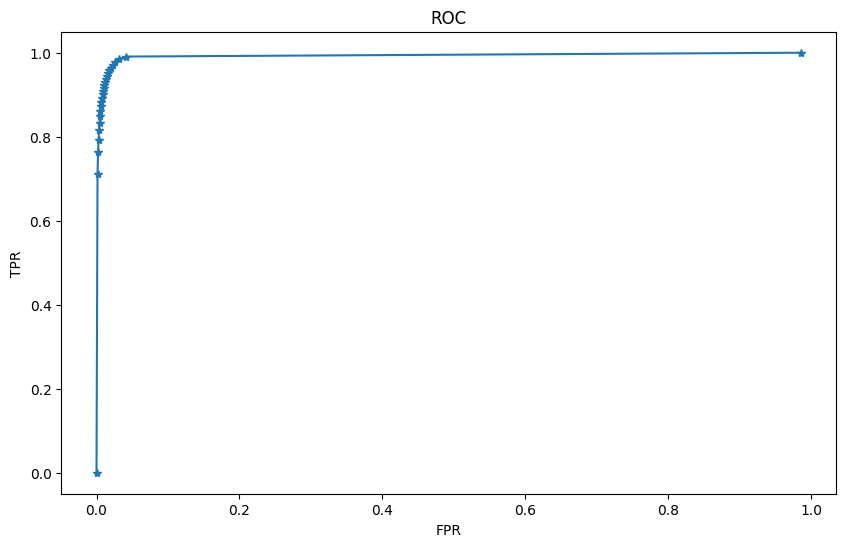

In [17]:
#predict outputs for training inputs
predictions = model.predict(X_train)

#since this is a binary classifier, just take the first column of probabilities
predictions = predictions[:,:,0]
y_train = y_train[:,:,1]

#calculate the probability threshold to optimize f1 score
results, thresh = roc(predictions, y_train)

Now, evaluate 5 random samples from the test set (unseen during training)

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step


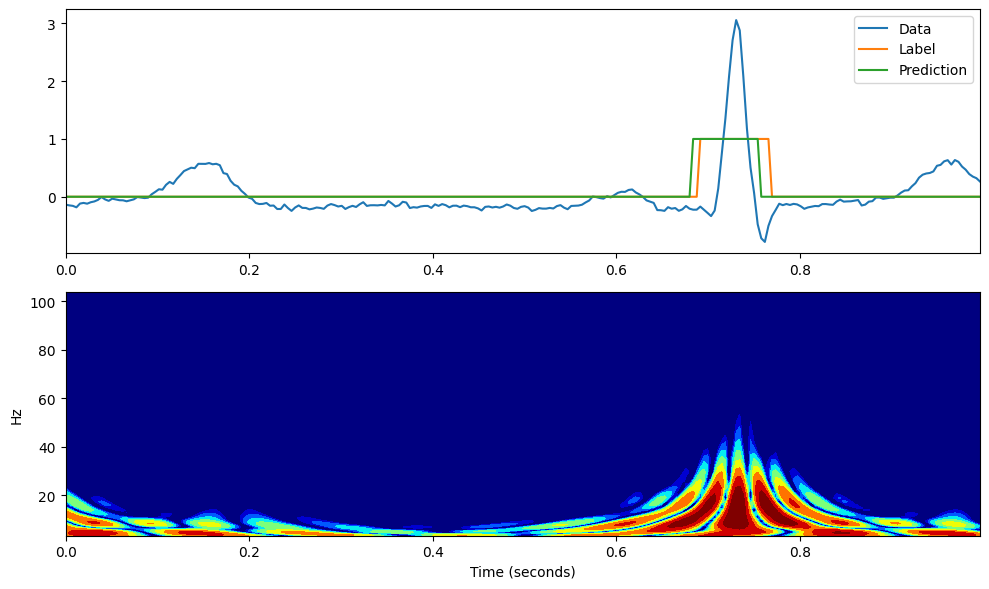

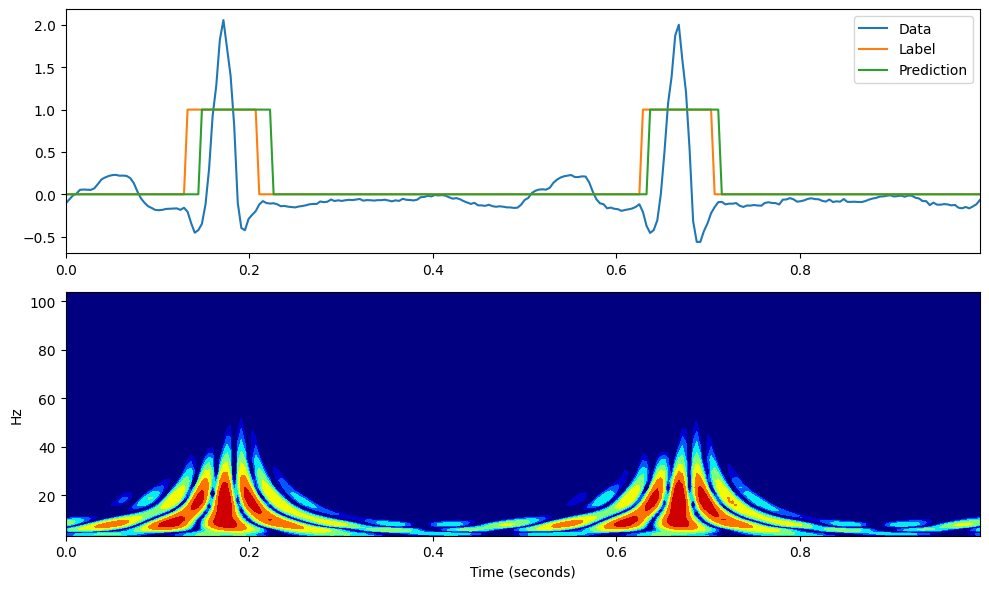

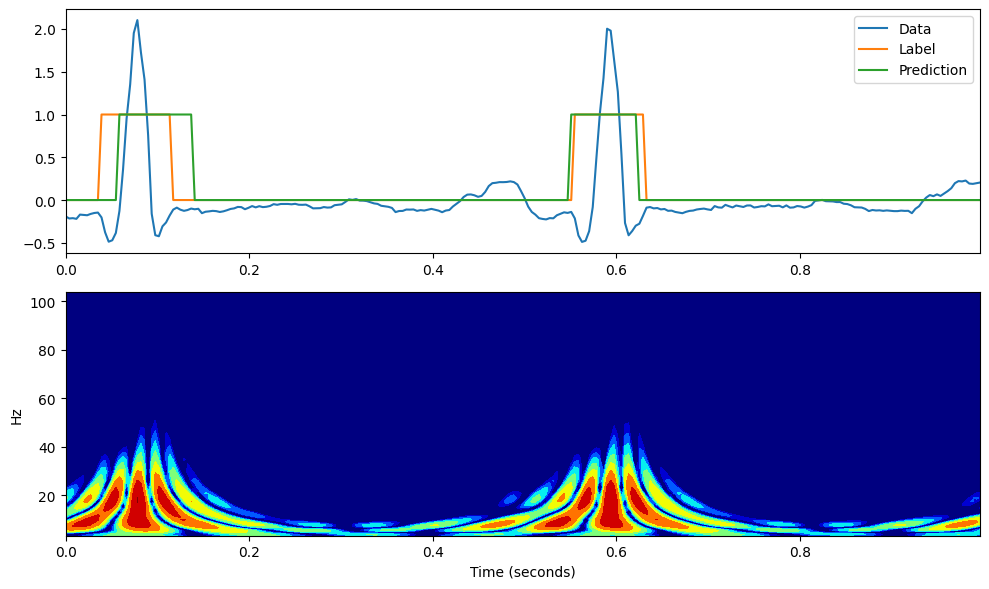

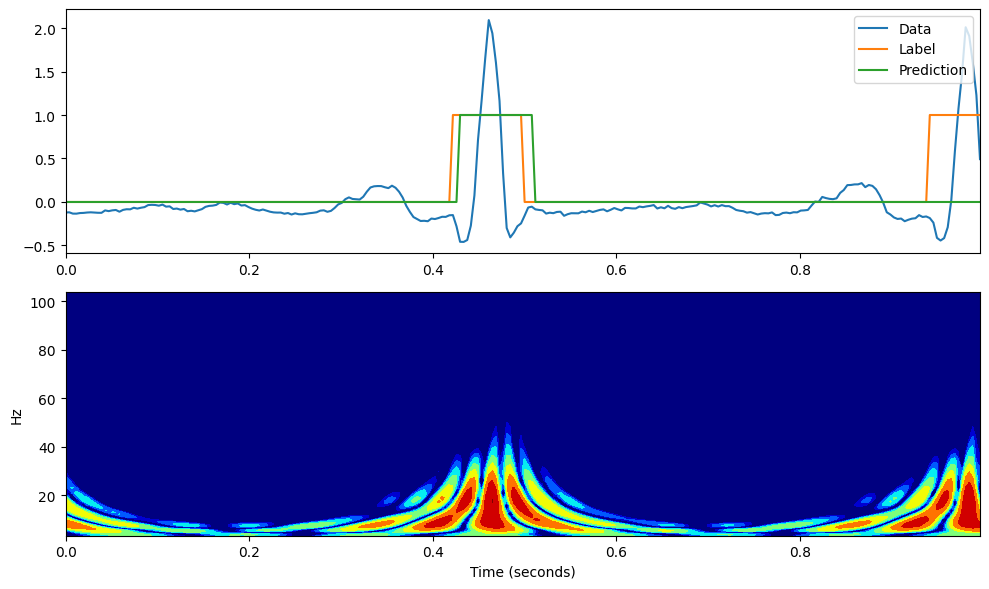

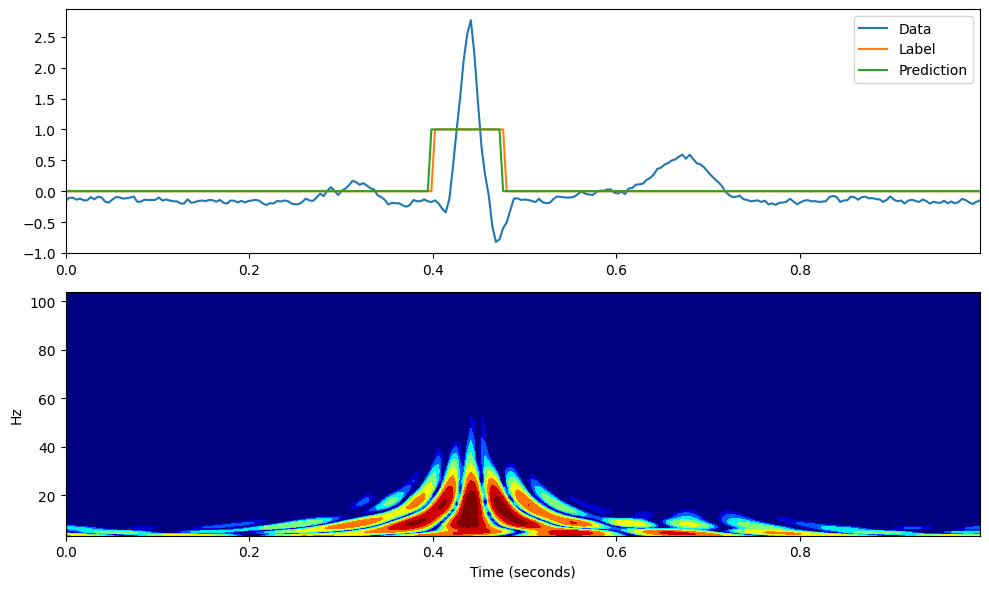

In [18]:
#predict outputs for test inputs
predictions = model.predict(X_test)

#since this is a binary classifier, just take the first column of probabilities
predictions = predictions[:,:,0]
y_test = y_test[:,:,1]

#threshold the probabilities
predictions = np.array([(p>thresh).astype(int) for p in predictions])

#plot some random results
inds = np.array(range(len(predictions)))
np.random.shuffle(inds)
for i in inds[0:5]:
    y_labels = y_test[i]
    predictions_tmp = 1-predictions[i]
    coefficients = np.reshape(X_test[i], (62, 256))
    data = ecg_test[i]

    power = (abs(coefficients))**2
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)

    plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    plt.plot(np.array(range(len(data)))/256, data, label='Data')
    plt.plot(np.array(range(len(data)))/256, y_labels, label='Label')
    plt.plot(np.array(range(len(data)))/256, predictions_tmp, label='Prediction')
    plt.legend(loc=1)
    ax2 = plt.subplot(212, sharex=ax1)
    plt.contourf(np.array(range(len(data)))/256, wavelet_freqs, np.log2(power), contourlevels, extend='both', cmap='jet')
    plt.ylabel('Hz')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig('predictions/%i.png' % i, dpi=125)
    plt.show()
    plt.close()


In [19]:
y_test.shape

(2987, 256)

Calculate the test set metrics

#flatten
predictions = 1-predictions.flatten()
y_test = y_test.flatten()

#calculate various metrics
f1 = f1_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
tpr = tp/(tp+fn)#also known as recall
precision = tp/(tp+fp)
fpr = fp/(tn+fp)
acc = (tp+tn)/(tn+fp+fn+tp)

tmp_dict = {'f1': f1, 'acc': acc, 'tpr': tpr, 'fpr': fpr, 'precision':precision,'thresh': thresh}
pd.DataFrame([tmp_dict])


In [20]:
#free up memory
flag = False
if flag:
    import gc
    del X_train, X_test, y_train, y_test, data_train, data_test
    gc.collect()